# Lab 6: Random Forest Regression on Malagasy Mammal Traits

### Introduction
 In Lab 5, we used functional trait data on bird species to predict their presence in a given climate type. This week we are using regression tree models on a similar dataset, this one on mammal species.  Our goal is to predict the total number of climate types each mammal species inhabits.

You will compare performance of a single decision tree with a tuned random forest to get a sense of the effectiveness of ensemble methods with optimized hyperparameter values.

There is a fair amount of missing data in this set, which can lead to low reliability of feature splits, increased overfitting, and decreased accuracy of tree models. You will address this issue with a combination of variable omission and imputation.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

### Step 1: Read data and retain a subset of the columns
Similar to last week, we will need to take some steps to get the data in a usable form. We again reformat the diet-related variable names to match this set: `Diet_Vertebrates`,
    `Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`. Then drop columns that are not relevant functional traits or climate type variables.   Next, drop any remaining  variables that have greater than 40% of the observations missing. Print the final dataframe shape. 

In [2]:
# ---- Read in project data ----
data = pd.read_csv("/courses/EDS232/Data/MamTraitData.csv", encoding="ISO-8859-1").rename(columns={
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; carcasses': 'Diet_Other'
})

# Check shape and number of NAs
print("Data shape:\n", data.shape,"\n")
print("NA Counts:\n", data.isna().sum()/214)

mammals_clean = data.drop(columns=['CranialCapacity', 'GestationLength', 'InterbirthInterval', 'HomeRange', 'PopulationDensity','SocialGrpSize', 'Longevity'])

print("\nFinal DataFrame shape: ", mammals_clean.shape)

Data shape:
 (214, 24) 

NA Counts:
 AdultBodyMass         0.014019
CranialCapacity       0.799065
Diet_Invertebrates    0.000000
Diet_Vertebrates      0.000000
Diet_Fruits           0.000000
Diet_Flowers          0.000000
Diet_Seeds            0.000000
Diet_Plants           0.000000
Diet_Other            0.000000
HabitatBreadth        0.121495
ActivityCycle         0.102804
ForagingStratum       0.112150
GestationLength       0.551402
LitterSize            0.387850
InterbirthInterval    0.602804
HomeRange             0.705607
PopulationDensity     0.761682
SocialGrpSize         0.635514
Longevity             0.612150
Dry                   0.000000
Humid                 0.000000
Montane               0.000000
Subarid               0.000000
Subhumid              0.000000
dtype: float64

Final DataFrame shape:  (214, 17)


### Step 2: Imputation with KNN
Now impute the values of the missing data in the remaining numeric columns using k-nearest neighbors with `KNNImputer()`. Use the 5 nearest neighbors. This allows us to implement the knn algorithm to predict the missing values for an observation based on similar complete observations.Perform and print a check to ensure that there are no more NA values. 

In [3]:
mammals_clean.dtypes

AdultBodyMass         float64
Diet_Invertebrates     object
Diet_Vertebrates       object
Diet_Fruits            object
Diet_Flowers           object
Diet_Seeds             object
Diet_Plants            object
Diet_Other             object
HabitatBreadth        float64
ActivityCycle         float64
ForagingStratum       float64
LitterSize            float64
Dry                     int64
Humid                   int64
Montane                 int64
Subarid                 int64
Subhumid                int64
dtype: object

In [4]:
# ---- Impute values of missing data with KNN ----

# Initialize the imputer
knn_impute = KNNImputer(n_neighbors = 5)
X_knn_impute = knn_impute.fit_transform(mammals_clean.select_dtypes(include='number'))
X_knn_impute = pd.DataFrame(X_knn_impute, columns = mammals_clean.select_dtypes(include='number').columns)

# Check to make sure that there are no NAs
X_knn_impute.isna().sum()

AdultBodyMass      0
HabitatBreadth     0
ActivityCycle      0
ForagingStratum    0
LitterSize         0
Dry                0
Humid              0
Montane            0
Subarid            0
Subhumid           0
dtype: int64

### Step 3: Create target variable and numerical encoding 
Create the target variable (`nClimates`) representing the  number of climates in which a species was present. Then finish preparing the data to be used in our models.

- Create a new column `nClimates` that combines the information of the five climate type variables
- Drop the original `Dry`, `Humid`, `Montane`, `Subarid`, and `Subhumid` columns
- Encode categorical variables
- Split the dataset into training and test sets. Use a random state of 808. 

In [5]:
# ---- Create target variable ----

# Create new col that represents number of climates a species is present
mammals_clean['nClimates'] = mammals_clean[['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid']].sum(axis=1)

# Drop climate cols
mammals_clean = mammals_clean.drop(columns=['Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid'])


# ---- Encode data ----

# Factorize columns
for col in mammals_clean.columns:
    mammals_clean.loc[:, col] = pd.factorize(mammals_clean[col], sort=True)[0]

# ---- Split data for training and testing ----

y = mammals_clean['nClimates']
X = mammals_clean.drop('nClimates', axis = 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=808)


### Step 4: Train a decision tree
Train a single decision tree to predict the number of climate types inhabited by each species.

- Train a `DecisionTreeRegressor`.  Let's apply a constraint on its growth by not allowing the tree to grow further than 5 levels. Use a random state of 808. 
- Make predictions
- Visualize the decision tree using `plot_tree`
- Evaluate and print its performance using mse

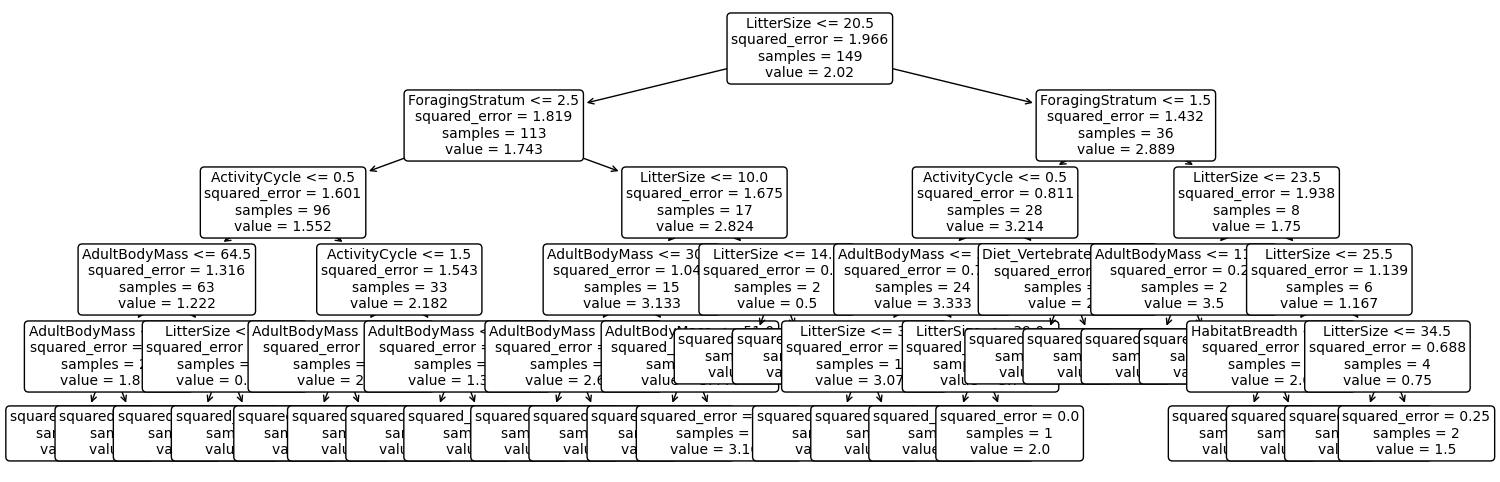

Mean Squared Error: 1.8125749965025268


In [23]:
# ---- Train & fit a decision tree ----
dtr = DecisionTreeRegressor(max_depth = 5, random_state = 808)
dtr.fit(X_train, y_train)

# Make predictions
y_pred = dtr.predict(X_test)

# ---- Visualize the decision tree using plot_tree ---
plt.figure(figsize = (18, 6))
plot_tree(dtr,
          feature_names = X_train.columns,
          class_names = ['Climate types'],
          rounded = True,
          fontsize = 10)
plt.show()

# ---- Evaluate and print mse ---
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Based on the way this tree looks, what would you guess the most important variable to be?

### Step 5: Random forest with hyperparameter tuning
Now we'll use a more sophisticated ensemble approach where we optimize the values of key hyperparameters that govern tree growth.

- Define a parameter grid that includes the follow parameters and values:
  -  (sqrt(p), 6, and no set #) of the number of features to try at each split
  -  (50, 100, 200) total trees (learners)
  -  a maximum tree depth of (3,4,5,6,7)
  -  (2,5,10) minimum samples per split
  -  (1,2,4) minimum samples per leaf
  
- Use `GridSearchCV` with 5-fold cross-validation and mse (`neg_mean_squared_error`) to find the best combination of parameter values
- Train the best estimator.

In [7]:
param_grid = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [5, 10, 20, None],
    "max_features": ["sqrt", 0, None],
    
}

gs = GridSearchCV(rf, param_grid = param_grid, n_jobs=-1, return_train_score = True)

Ellipsis

### Step 6: Make predictions and evaluate random forest model
Use the optimized random forest model (`best_rf`) to predict the number of climates a species inhabits and analyze its performance.

- Use `best_rf` and `predict()` method on `X_test` to generate predictions
- Print the best set of parameter values using thte `best_params` method
- Compute and print the mse to evaluate model performance
- Extract feature importance from the trained random forest model
- Visualize feature importance using a bar plot

In [8]:
...

Ellipsis

Which model had better accuracy, the single tree or the ensemble.  Interpret which traits have the most influence on species' climate adaptability.

*Your answer here.*